In [1]:
# !pip install transformers accelerate datasets diffusers Pillow==9.4.0

For Imagenet processing we have to do things a bit different:
* Load recaptioned dataset
* Resize using HF's built-in multiprocessing
* Generate latents in batches
* Reupload to HF

In [2]:
import torchvision.transforms as T
import torch
import random
from datasets import load_dataset, Dataset, DatasetDict
from diffusers import AutoencoderDC
from torch.utils.data import DataLoader
from utils import make_grid, PIL_to_latent, latent_to_PIL, dcae_scalingf
from tqdm import tqdm

from PIL import PngImagePlugin
# otherwise might lead to Decompressed Data Too Large for some images
LARGE_ENOUGH_NUMBER = 10
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

/home/g/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
from local_secrets import hf_token
from huggingface_hub import login
login(token=hf_token)

# Load IN1k recaptions dataset

In [4]:
ds = load_dataset("visual-layer/imagenet-1k-vl-enriched", cache_dir="~/ssd-2TB/hf_cache")
ds

Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/207 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/205 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'],
        num_rows: 50000
    })
})

In [5]:
print("splits", ds.keys())
print("features", ds["train"].features.keys())

splits dict_keys(['train', 'validation'])
features dict_keys(['image_id', 'image', 'label', 'caption_enriched', 'label_bbox_enriched', 'issues'])


## Inspect augmentation before actually processing

a man wearing a ski mask and scarf



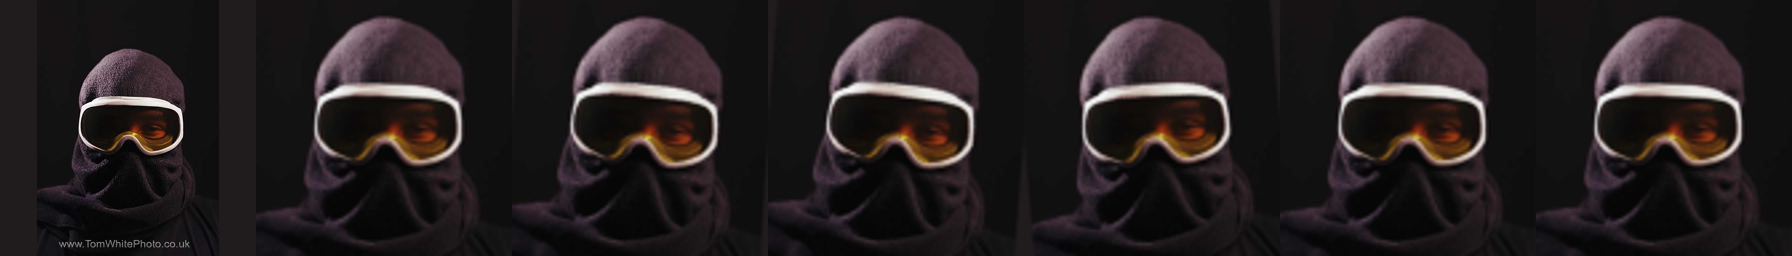

a dog playing with a toy in the grass



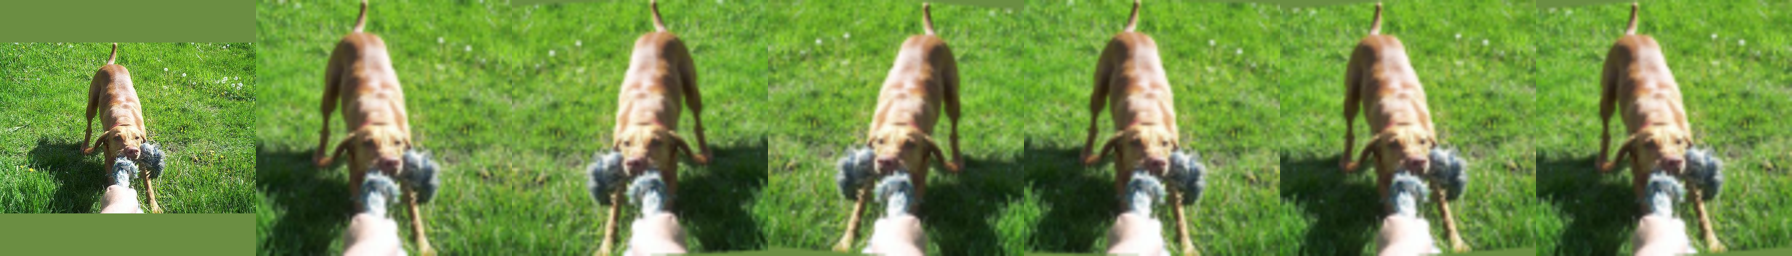

a barber shop with a few men sitting at the barber chairs



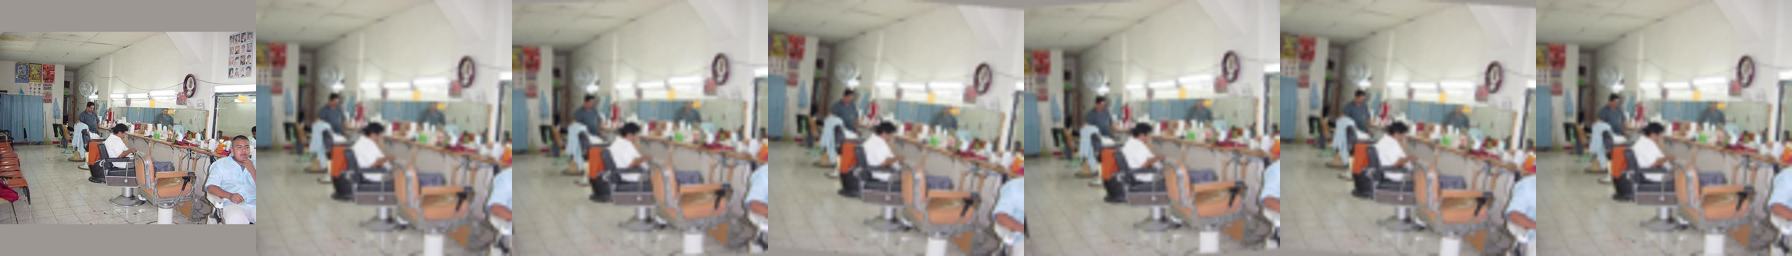

a baby sitting on a bed with orange toys



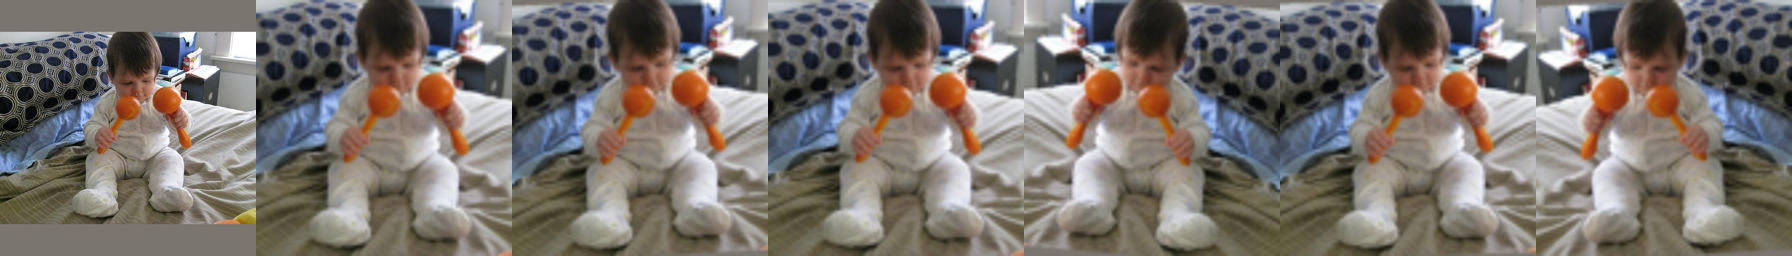

a mannequin head with blonde hair and a face



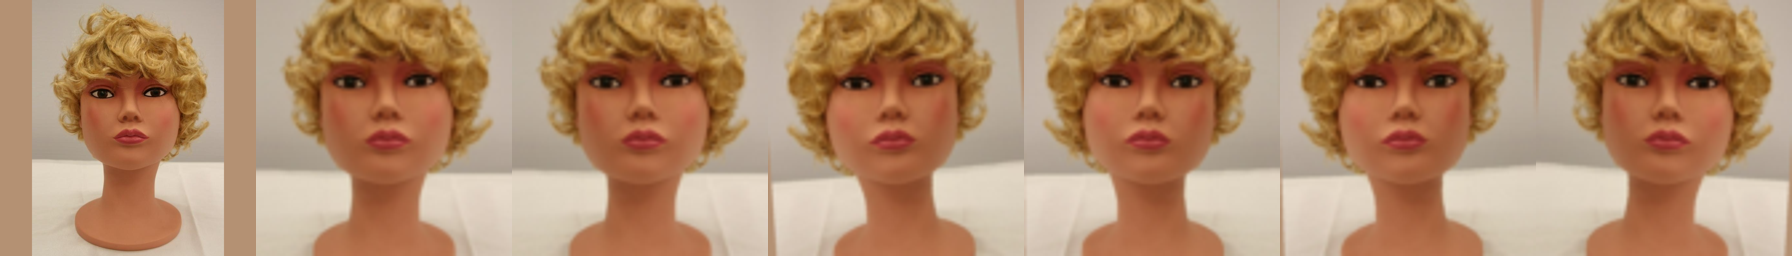

three men are holding a large wooden puzzle



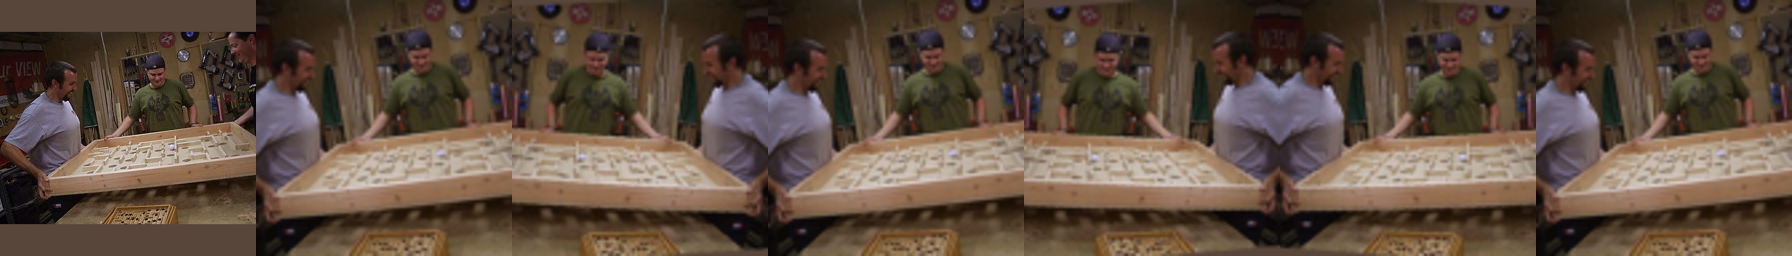

a table with wine glasses



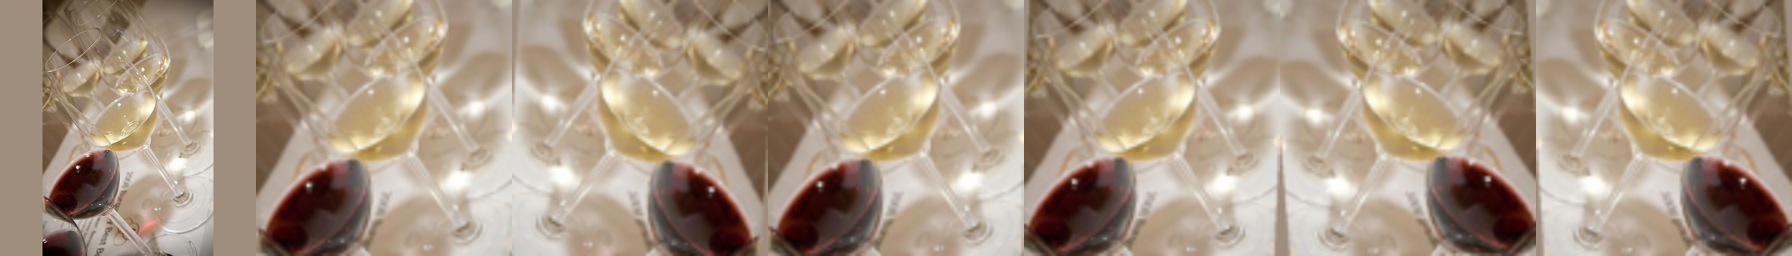

a train bridge over a river



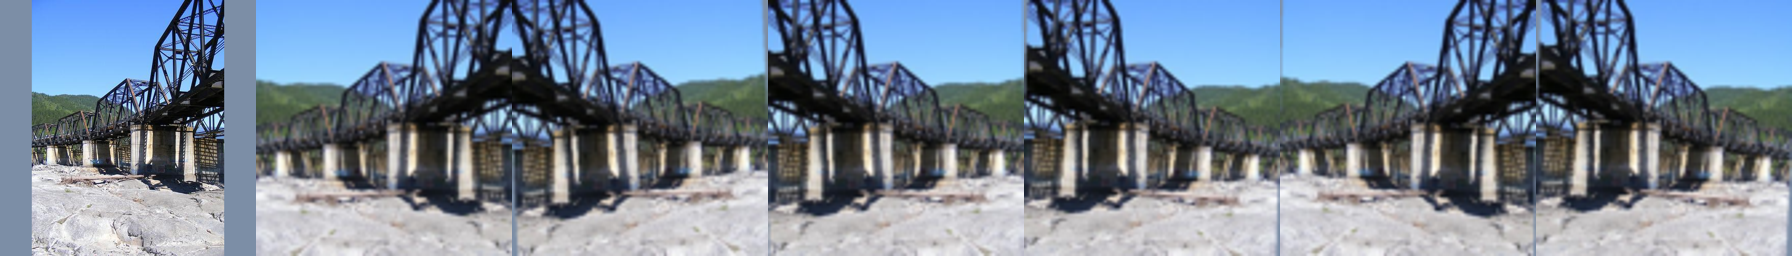

a person is playing with a bat



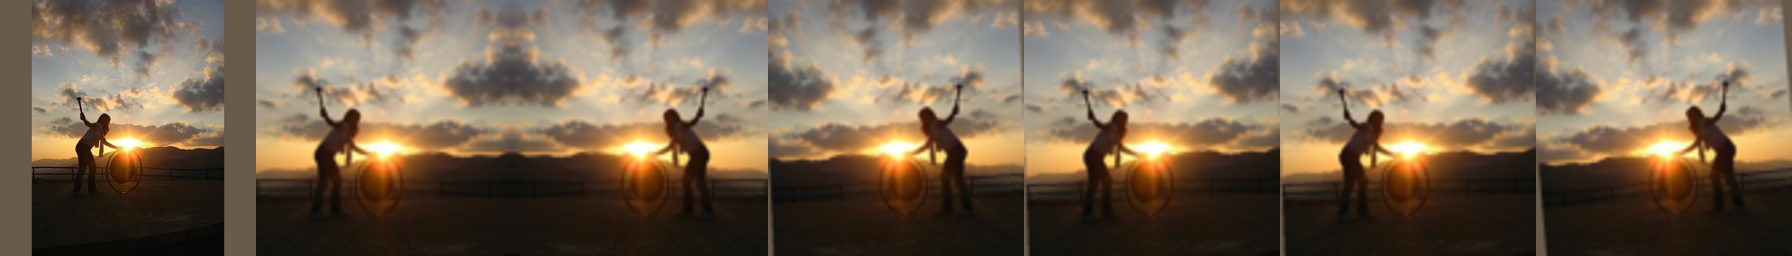

a needle with a drop of liquid on it



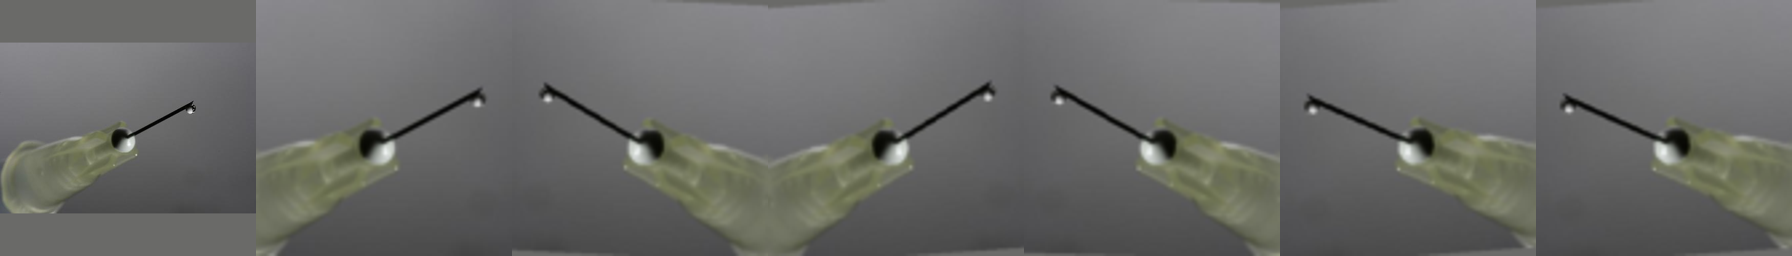

In [6]:
resizeTo = 96
split = "train"

import numpy as np 

def pad(img):
    w, h = img.size
    diff = abs(w-h)
    transform = T.Pad([0, diff//2] if w>h else [diff//2, 0], fill=get_average_color(img))
    return transform(img)

def get_average_color(img):
    img_array = np.array(img)
    return tuple(map(int, img_array.mean(axis=(0,1))))

def resize_and_augment(img, do_augment=False):
    def noop(x): return x
    img = img.convert('RGB') if img.mode!="RGB" else img
    transform = T.Compose([
        T.RandomHorizontalFlip(p=0.5 if do_augment else 0),
        T.RandomRotation([-5,5],expand=False, fill=get_average_color(img)) if do_augment else noop,
        T.Resize(resizeTo, antialias=True),
        T.CenterCrop(resizeTo),
    ])
    return transform(img)
    
for i in [random.randint(0, len(ds[split])) for _ in range(10)]:
    img=ds[split][i]["image"]
    label=ds[split][i]["caption_enriched"]
    images = []
    
    images.append( pad(img).resize((256,256)) )
    images.append( resize_and_augment(img, do_augment=False).resize((256,256)) )
    images.extend( [resize_and_augment(img, do_augment=True).resize((256,256)) for _ in range(5)] )

    print(label)
    display(make_grid(images))

# Load DCAE

In [7]:
model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)

# Batch augment and create dataset

In [8]:
worker=1
num_workers=4

print("before")
for split in list(ds.keys()):
    print(split, len(ds[split]))

for split in list(ds.keys()):
    total_size = len(ds[split]) 
    part_size = total_size // num_workers
    start_idx = (worker-1) * part_size
    end_idx = worker * part_size if worker != num_workers else total_size  # Handle the last part
    ds[split] = ds[split].select(range(start_idx, end_idx))

print("after")
for split in list(ds.keys()):
    print(split, len(ds[split]))

before
train 1281167
validation 50000
after
train 320291
validation 12500


In [ ]:
def collate(items):
    labels = [item["caption_enriched"] for item in items]
    images = [
        [resize_and_augment(item["image"], do_augment=True if i>0 else False) for i in range(augs_per_img + 1)]
        for item in items
    ]
    return labels, images

test_run = False
hf_dataset = "g-ronimo/IN1k96-augmented-latents_dc-ae-f32c32-sana-1.0"
augs_per_img = 4
batch_size = 256
# upload_every = 1_000 // batch_size  # upload_every is #batches
upload_every = 100_000 // batch_size  # upload_every is #batches
splits=["train", "validation"]
dtype=torch.bfloat16

for split in splits:
    # Change the dataset !
    dataloader = DataLoader(
        ds[split], 
        batch_size = batch_size, 
        shuffle=False, 
        collate_fn=collate,
        num_workers=6,
        prefetch_factor=10,
    )
    dataset_latents = []
    dataset_part = 0
    num_batches = len(dataloader)
    print(f"split {split}, {num_batches} batches, uploading every {upload_every}")
    
    for batch_num, (labels, images) in tqdm(enumerate(dataloader),total=len(dataloader), desc=f"split {split}"):
        # images is list of lists: [[img1, img1_aug1, img1_aug2,..], [img2, img2_aug1,..] 
        images_batch = []   # all images
        for i in images: images_batch.extend(i)
        # latents_batch shape [batch size * augs_per_img, 32, 3, 3]
        latents_batch = PIL_to_latent(images_batch, dcae).cpu()   # shape [B * latents_per_img, ..., C, W, H]
        latents_batch = latents_batch.to(dtype)  # bfloat16 !
        
        for i, label in enumerate(labels):
            idx_start, idx_end = i*(augs_per_img+1), (i+1)*(augs_per_img+1)
            latents = latents_batch[idx_start:idx_end]
            # if test_run: print(latents.shape)
            dataset_latents.append({
                "label": label,
                "latent": latents 
            })
        if (batch_num+1) % upload_every == 0 or (batch_num+1) % num_batches == 0:
            print(f"Uploading part {dataset_part} of split {split} to {hf_dataset}")
            Dataset.from_list(dataset_latents).push_to_hub(hf_dataset, split=f"{split}.{worker}.{dataset_part}", num_shards=1)
            dataset_part+=1
            dataset_latents=[]            
        if test_run: break
            

split train, 1252 batches, uploading every 390


split train:  31%|██████████▊                        | 389/1252 [27:10<1:23:12,  5.78s/it]

Uploading part 0 of split train to g-ronimo/IN1k96-augmented-latents_dc-ae-f32c32-sana-1.0


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/505 [00:00<?, ?B/s]

split train:  37%|█████████████▌                       | 460/1252 [42:02<41:56,  3.18s/it]

In [1]:
latents.dtype

NameError: name 'latents' is not defined

In [ ]:
# check a few samples
num_samples = 12
dataset = dataset_latents
for split in dataset_latents:
    print("split", split)
    for idx in [random.randint(0, len(dataset[split])-1) for _ in range(num_samples)]:
        latent = torch.Tensor(dataset[split][idx]["latent"])
        label = dataset[split][idx]["label"]
        print(label, latent.shape)
        display(
            make_grid(
                latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae)
            )
        )

# Upload

In [ ]:
# dataset = DatasetDict({
#     split: Dataset.from_list(dataset_latents[split]) 
#     for split in dataset_latents
# })
# dataset

In [ ]:
# # check a few samples
# for split in splits:
#     print("split", split)
#     for idx in [random.randint(0, len(dataset[split])-1) for _ in range(5)]:
#         latent = torch.Tensor(dataset[split][idx]["latent"])
#         label = dataset[split][idx]["label"]
#         print(label, latent.shape)
#         display(
#             make_grid(
#                 latent_to_PIL(latent.to(dcae.dtype).to(dcae.device), dcae)
#             )
#         )

In [ ]:
# from local_secrets import hf_token
# from huggingface_hub import login
# login(token=hf_token)

In [ ]:
# dataset.push_to_hub(
#     "g-ronimo/IN1k96-augmented-latents_dc-ae-f32c32-sana-1.0", 
#     private=True, 
#     commit_message=model,
#     num_shards={'train': 10, 'validation': 4}
# )